This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
#from keras.preprocessing.image import ImageDataGenerator

c:\users\nlmluk\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\nlmluk\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
PATH = 'C:/Git/100_tiramisu/camvid-master/'

The images in CamVid come with labels defining the segments of the input image. We're going to load both the images and the labels.

In [3]:
frames_path = PATH+'701_StillsRaw_full/'

In [4]:
labels_path = PATH+'LabeledApproved_full/'

In [5]:
fnames = glob.glob(frames_path+'*.png')

In [6]:
frames_path

'C:/Git/100_tiramisu/camvid-master/701_StillsRaw_full/'

In [7]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]

In [8]:
img_sz = (480,360)

Helper function to resize images.

In [9]:
def open_image(fn): 
      return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [10]:
#imgs = np.stack([open_image(fn) for fn in fnames])
#labels = np.stack([open_image(fn) for fn in lnames])
#save_array(PATH+'results/imgs.bc', imgs)
#save_array(PATH+'results/labels.bc', labels)

In [11]:
imgs = load_array(PATH+'results/imgs.bc')
labels = load_array(PATH+'results/labels.bc')

In [12]:
imgs.shape,labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

Normalize pixel values.

In [13]:
imgs = imgs/255.
mean = imgs.mean() 
std = imgs.std()
imgs-=imgs.mean()
imgs/=imgs.std()
mean, std

(0.39996644266360826, 0.3017949114229091)

## Preprocessing

### Generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [14]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [15]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([4, 2, 8]),
 array([0, 5, 6]),
 array([3, 7, 1]),
 array([9]),
 array([8, 6, 3])]

In [16]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the first image.

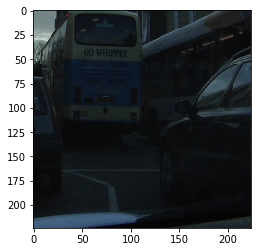

In [17]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

In [18]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [19]:
label_codes, label_names = zip(*[parse_code(l) for l in open(PATH+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

32

In [20]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [21]:
failed_code = len(label_codes)+1
failed_code

33

In [22]:
n,r,c,ch = imgs.shape
n, r, c, ch

(701, 360, 480, 3)

In [23]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [24]:
def conv_all_labels():
    return np.stack(map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

In [25]:
#labels_int = conv_all_labels()
#save_array(PATH+'results/labels_int.bc', labels_int)

In [26]:
labels_int = load_array(PATH+'results/labels_int.bc')
labels_int.shape

(701, 360, 480)

In [27]:
np.count_nonzero(labels_int==failed_code)

44

Set erroneous pixels to zero.

In [28]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

1


In [29]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

700

In [30]:
np.count_nonzero(labels_int==failed_code)

0

In [31]:
imgs = np.delete(imgs, l, axis=0)
len(imgs)

700

In [32]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

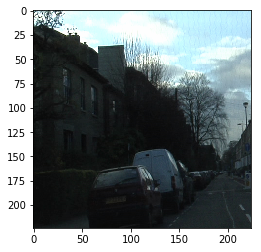

In [33]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4)

In [34]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

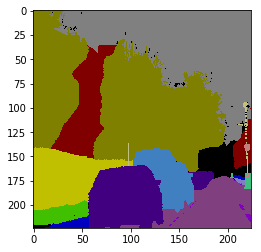

In [35]:
temp = dict_color_label(b_label[0])
plt.imshow(color_label(np.resize(temp, (224,224))))

### Test set

Next we load test set, set training/test images and labels.

In [36]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [37]:
train_set.shape

(468, 360, 480, 3)

In [38]:
test_set.shape

(232, 360, 480, 3)

In [39]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [40]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return Concatenate(axis=-1)(xs)

In [41]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, (sz, sz), strides=(stride, stride), padding='same', kernel_initializer='he_uniform',  
                       kernel_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [42]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [43]:
def transition_dn(x, p, wd):
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [44]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [45]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform', 
                 kernel_regularizer=regularizers.l2(wd))(x)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [46]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [47]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [48]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

In [49]:
input_shape = (224,224,3)

In [50]:
train_generator = segm_generator(train_set, train_labels, 1, train=True)
test_generator = segm_generator(test_set, test_labels, 1, train=False)

In [51]:
img_input = Input(shape=input_shape)

In [52]:
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [53]:
model = Model(img_input, x)

In [54]:
#model.compile(loss='sparse_categorical_crossentropy', 
              #optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [55]:
#model.fit_generator(train_generator, len(train_set), 5, verbose=2,
                    #validation_data=test_generator, validation_steps=len(test_set))

In [107]:
model.load_weights('tiramisu_plus30_iterations_3e4.h5')

In [108]:
#model.save_weights('drive/Colab Notebooks/part 2/tiramisu_5_iterations.h5')

## View results

In [116]:
index = 200
frame_row_start = 130
frame_row_end = 354
frame_col_start = 150
frame_col_end = 374

In [117]:
try_image_test = np.expand_dims(test_set[index,frame_row_start:frame_row_end, frame_col_start:frame_col_end], 0)
try_image_test_label = test_labels[index,frame_row_start:frame_row_end, frame_col_start:frame_col_end]

In [118]:
for i in range(index):
    try_image_test, try_image_test_label = next(test_generator)

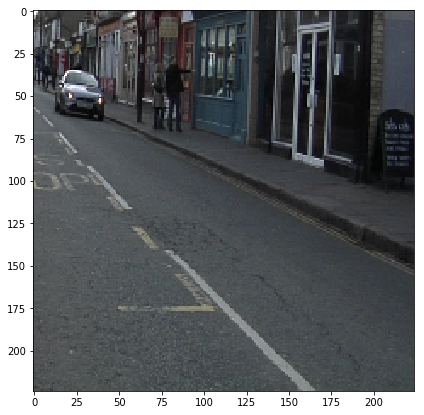

In [119]:
   plt.figure(figsize=(7,7))
plt.imshow(try_image_test[0]*0.3+0.4)

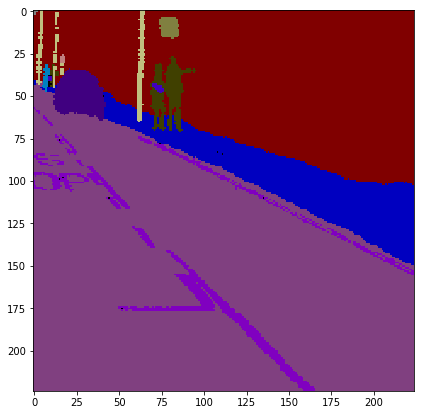

In [120]:
plt.figure(figsize=(7,7))
plt.imshow(color_label(np.resize(try_image_test_label, (224,224))))

In [121]:
p = model.predict(try_image_test)
p = np.argmax(p, axis=-1)
p.shape

(1, 50176)

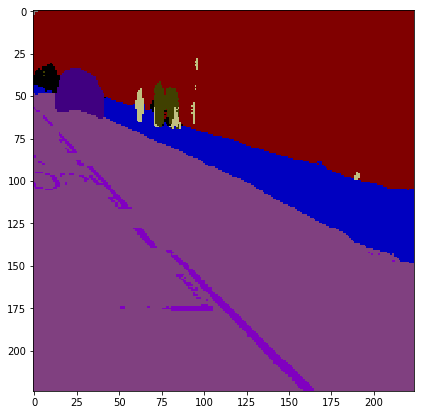

In [122]:
plt.figure(figsize=(7,7))
plt.imshow(color_label(np.resize(p[0], (224,224))))